# Load functions and packages
### 3 blosum related functions copied from https://www.biorxiv.org/content/10.1101/433706v1.full

In [1]:
from __future__ import print_function
import sys
import os
import time

import math
import numpy as np
import tensorflow as tf

print(tf.__version__)

2.2.0-dev20200401


C:\Users\Anjin\Anaconda3\lib\site-packages\tensorboard\compat\tensorflow_stub\dtypes.py:541: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\Anjin\Anaconda3\lib\site-packages\tensorboard\compat\tensorflow_stub\dtypes.py:542: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\Anjin\Anaconda3\lib\site-packages\tensorboard\compat\tensorflow_stub\dtypes.py:543: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\Anjin\Anaconda3\lib\site-packages\tensorboard\compat\tensorflow_stub\dtypes.

In [2]:



def read_blosum_MN(filename):
    '''
    read in BLOSUM matrix
    parameters:
        - filename : file containing BLOSUM matrix
    returns:
        - blosum : dictionnary AA -> blosum encoding (as list)
    '''

    # read BLOSUM matrix:
    blosumfile = open(filename, "r")
    blosum = {}
    B_idx = 99
    Z_idx = 99
    star_idx = 99

    for l in blosumfile:
        l = l.strip()

        if l[0] != '#':
            l= list(filter(None,l.strip().split(" ")))

            if (l[0] == 'A') and (B_idx==99):
                B_idx = l.index('B')
                Z_idx = l.index('Z')
                star_idx = l.index('*')
            else:
                aa = str(l[0])
                if (aa != 'B') &  (aa != 'Z') & (aa != '*'):
                    tmp = l[1:len(l)]
                    # tmp = [float(i) for i in tmp]
                    # get rid of BJZ*:
                    tmp2 = []
                    for i in range(0, len(tmp)):
                        if (i != B_idx) &  (i != Z_idx) & (i != star_idx):
                            tmp2.append(float(tmp[i]))

                    #save in BLOSUM matrix
                    #tmp2 = [i * 0.2 for i in tmp2] #scale (divide by 5)
                    blosum[aa]=tmp2
    blosumfile.close()
    blosum["B"]=np.ones(21)*0.1
    blosum["E"]=np.ones(21)*(-0.1)
    return(blosum)


def enc_list_bl(aa_seqs, blosum):
    '''
    blosum encoding of a list of amino acid sequences with padding
    parameters:
        - aa_seqs : list with AA sequences
        - blosum : dictionnary: key= AA, value= blosum encoding
    returns:
        - enc_aa_seq : list of np.ndarrays containing padded, encoded amino acid sequences
    '''
    

    # encode sequences:
    sequences=[]
    for seq in aa_seqs:
        e_seq=np.zeros((len(seq),len(blosum["A"])))
        count=0
        for aa in seq:
            if aa in blosum:
                e_seq[count]=blosum[aa]
                count+=1
            else:
                sys.stderr.write("Unknown amino acid in peptides: "+ aa +", encoding aborted!\n")
                sys.exit(2)
        sequences.append(e_seq)

    # pad sequences:
    max_seq_len = 11#max([len(x) for x in aa_seqs])
    n_seqs = len(aa_seqs)
    n_features = sequences[0].shape[1]

    enc_aa_seq = np.zeros((n_seqs, max_seq_len, n_features))
    for i in range(0,n_seqs):
        enc_aa_seq[i, :sequences[i].shape[0], :n_features] = sequences[i]

    return enc_aa_seq

def enc_list_bl_start_stop(aa_seqs, blosum):
    '''
    blosum encoding of a list of amino acid sequences with padding
    parameters:
        - aa_seqs : list with AA sequences
        - blosum : dictionnary: key= AA, value= blosum encoding
    returns:
        - enc_aa_seq : list of np.ndarrays containing padded, encoded amino acid sequences
    '''

    # encode sequences:
    sequences=[]
    for seq in aa_seqs:
        # replace O (pyrrolysine) with lysine (K):
        #seq.replace("0", "K")
        e_seq=np.zeros((len(seq)+2,len(blosum["A"])))
        # start encoding:
        e_seq[0]=np.ones(len(blosum["A"]))*0.1
        # sequence encoding:
        count=1
        for aa in seq:
            if aa == "O":
                aa ="K"
            if aa in blosum:
                e_seq[count]=blosum[aa]
                count+=1
            else:
                sys.stderr.write("Unknown amino acid: "+ aa +", encoding aborted!\n")
                sys.exit(2)
        # end encoding:
        e_seq[count]=np.ones(len(blosum["A"]))*(-0.1)
        # save:
        sequences.append(e_seq)

    # pad sequences:
    max_seq_len =28# max([len(x) for x in aa_seqs]) +2
    n_seqs = len(aa_seqs)
    n_features = sequences[0].shape[1]

    enc_aa_seq = np.zeros((n_seqs, max_seq_len, n_features))
    for i in range(0,n_seqs):
        enc_aa_seq[i, :sequences[i].shape[0], :n_features] = sequences[i]

    return enc_aa_seq



In [3]:
os.getcwd()

'C:\\Users\\Anjin'

In [4]:
##Read blosum file and generate blosum dictionary
blosumfile='C:/Users/Anjin/Downloads/blosum.txt'
blosum = read_blosum_MN(blosumfile)


# Feature engineering 
### to recover the chemical and physical properties of amino acid sequences

In [5]:
##To recover the electronic properties of the amino acid residues, I groups the aa with similar electronic properties together
'''
This function returns the amino acid abbreviation letters to the corresponding hydrophobicity property group: 
hydrophobic (1), amphipathic (2), and hydrophilic (3)

'''


def hydrophobicity_aa(argument):

    switcher = { 
        "A": 1,
        "V": 1,
        "L": 1,
        "F": 1,
        "I": 1,
        "P": 1,
        "G": 1,
        "W": 2,
        "Y": 2,
        "M": 2,
        "S": 3,
        "T": 3,
        "D": 3,
        "E": 3,
        "N": 3,
        "Q": 3,
        "R": 3,
        "H": 3,
        "K": 3,        
        "C": 3,
        "U": 3
      
    }
    return switcher.get(argument, "Invalid")






'''
This function returns the amino acid abbreviation letters to the corresponding charge property group: 
negatively charged (1), neutral (2), and positively (3)


'''

def charge_aa(argument):

    switcher = {
        "D": 1,
        "E": 1,
        "A": 2,
        "V": 2,
        "L": 2,
        "F": 2,
        "I": 2,
        "P": 2,
        "G": 2,
        "W": 2,
        "Y": 2,
        "M": 2,
        "S": 2,
        "T": 2,
        "N": 2,
        "Q": 2,
        "C": 2,
        "U": 2,
        "R": 3,
        "H": 3,
        "K": 3        

    }
    return switcher.get(argument, "Invalid")





'''
This function returns the amino acid abbreviation letters to the corresponding helicity property group: 
normal (1), helix breaker (2)


'''

def helicity_aa(argument):

    switcher = {
        "D": 1,
        "E": 1,
        "A": 1,
        "V": 1,
        "L": 1,
        "F": 1,
        "I": 1,
        "W": 1,
        "Y": 1,
        "M": 1,
        "S": 1,
        "T": 1,
        "N": 1,
        "Q": 1,
        "C": 1,
        "U": 1,
        "R": 1,
        "H": 1,
        "K": 1, 
        "P": 2,
        "G": 2

    }
    return switcher.get(argument, "Invalid")


In [6]:
## to recover the physical properties/residue size, I translate the aa into their molecular mass.
'''
This function returns the amino acid abbreviation letters to the corresponding molecular mass, 
normalized by the largest amino acid molecular mass
'''
def size_aa(argument):
    switcher = {
        "R": 174.20/204.23,
        "H": 155.16/204.23,
        "K": 146.19/204.23,
        "D": 133.11/204.23,
        "E": 147.13/204.23,
        "S": 105.09/204.23,
        "T": 119.12/204.23,
        "N": 132.12/204.23,
        "Q": 146.15/204.23,
        "C": 121.16/204.23,
        "U": 139.11/204.23,
        "G": 75.07/204.23,
        "P": 115.13/204.23,
        "A": 89.10/204.23,
        "I": 131.18/204.23,
        "L": 131.18/204.23,
        "M": 149.21/204.23,
        "F": 165.19/204.23,
        "W": 204.23/204.23,
        "Y": 181.19/204.23,
        "V": 117.15/204.23,
    }
    return switcher.get(argument, "Invalid")

# Load data

In [7]:
import pandas as pd
import numpy as np
df=pd.read_csv('C:/Users/Anjin/Downloads/vdj_v1_hs_aggregated_donor1_binarized_matrix.csv')
##read the TCR & antigen binding data from the first donor|


In [8]:
df

,barcode,donor,cell_clono_cdr3_aa,cell_clono_cdr3_nt,CD3,CD19,CD45RA,CD4,CD8a,CD14,...,B0702_RPHERNGFTVL_pp65_CMV_binder,B0801_RAKFKQLL_BZLF1_EBV_binder,B0801_ELRRKMMYM_IE-1_CMV_binder,B0801_FLRGRAYGL_EBNA-3A_EBV_binder,A0101_SLEGGGLGY_NC_binder,A0101_STEGGGLAY_NC_binder,A0201_ALIAPVHAV_NC_binder,A2402_AYSSAGASI_NC_binder,B0702_GPAESAAGL_NC_binder,NR(B0801)_AAKGRGAAL_NC_binder
0,AAACCTGAGACAAAGG-4,donor1,TRA:CAASVSIWTGTASKLTF;TRA:CAAWDMEYGNKLVF;TRB:C...,TRA:TGTGCAGCAAGCGTTAGTATTTGGACCGGCACTGCCAGTAAA...,2125.0,0.0,912.0,1.0,2223.0,4.0,...,False,False,False,False,False,False,False,False,False,False
1,AAACCTGAGACTGTAA-34,donor1,TRB:CASDTPVGQFF,TRB:TGTGCCAGCGATACCCCGGTTGGGCAGTTCTTC,1023.0,0.0,2028.0,2.0,3485.0,1.0,...,False,False,False,False,False,False,False,False,False,False
2,AAACCTGAGAGCCCAA-5,donor1,TRA:CASYTDKLIF;TRB:CASSGGSISTDTQYF,TRA:TGTGCTTCCTACACCGACAAGCTCATCTTT;TRB:TGCGCCA...,1598.0,3.0,3454.0,4.0,3383.0,1.0,...,False,False,False,False,False,False,False,False,False,False
3,AAACCTGAGAGCTGCA-24,donor1,TRB:CASSGGQSSYEQYF,TRB:TGCGCCAGCAGTGGCGGACAGAGCTCCTACGAGCAGTACTTC,298.0,1.0,880.0,1.0,2389.0,1.0,...,False,False,False,False,False,False,False,False,False,False
4,AAACCTGAGAGGGATA-8,donor1,TRA:CAASGYGNTGRRALTF;TRB:CASSQDPAGGYNEQFF,TRA:TGTGCAGCAAGCGGGTATGGAAACACGGGCAGGAGAGCACTT...,1036.0,0.0,2457.0,2.0,3427.0,3.0,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
46521,TTTGTCATCGAGGTAG-13,donor1,TRA:CATDGSSGGSNYKLTF;TRB:CASSTSNEQPQHF,TRA:TGTGCTACGGACGGAAGTAGTGGAGGTAGCAACTATAAACTG...,241.0,1.0,44.0,1.0,731.0,3.0,...,False,False,False,False,False,False,False,False,False,False
46522,TTTGTCATCTCCAACC-24,donor1,TRA:CAASPGGYSTLTF;TRB:CASSSDGQSSYNEQFF,TRA:TGTGCAGCAAGCCCCGGGGGATACAGCACCCTCACCTTT;TR...,821.0,2.0,2907.0,2.0,2626.0,3.0,...,False,False,False,False,False,False,False,False,False,False
46523,TTTGTCATCTCCTATA-36,donor1,TRA:CADHGGATNKLIF;TRB:CASSTGAGVNEQYF,TRA:TGTGCAGACCATGGTGGTGCTACAAACAAGCTCATCTTT;TR...,1216.0,3.0,802.0,3.0,5506.0,1.0,...,False,False,False,False,False,False,False,False,False,False
46524,TTTGTCATCTGTCAAG-32,donor1,TRA:CALSEARNYGQNFVF;TRB:CASSLGASRSTDTQYF,TRA:TGTGCTCTGAGTGAGGCGCGAAACTATGGTCAGAATTTTGTC...,913.0,2.0,241.0,3.0,4665.0,0.0,...,False,False,False,False,False,False,False,False,False,False


## Select Antigens

In [9]:
df_2=pd.read_csv('C:/Users/Anjin/Downloads/CMV_epitopes_vj.csv')
antigen_selection=[]
for i in np.unique(df_2['Epitope']):
    print(len(df_2.iloc[np.where(df_2['Epitope']==i)[0],:]))
    if len(df_2.iloc[np.where(df_2['Epitope']==i)[0],:])>0:
        antigen_selection.append(i)
#antigen_selection.append('KLGGALQAK')
antigen_selection

7
35
505
25
157
291
278


['ELRRKMMYM',
 'IPSINVHHY',
 'NLVPMVATV',
 'QYDPVAALF',
 'RPHERNGFTVL',
 'TPRVTGGGAM',
 'VTEHDTLLY']

In [10]:
##only the CMV related antigens were used here. 
CMV_seq=[]
for idx, i in enumerate(df.columns):
    if '_binder' in i:
        for e in antigen_selection:
            if e in i:
                CMV_seq.append(idx)#Generate the column numbers of CMV antigen 
#CMV_seq=[range]
#CMV_seq=[* range(86,98,1)]
CMV_seq=np.unique(CMV_seq)
CMV_seq

array([ 68,  84, 102, 104, 106, 108, 110])

In [11]:
df.columns[CMV_seq]

Index(['A0101_VTEHDTLLY_IE-1_CMV_binder', 'A0201_NLVPMVATV_pp65_CMV_binder',
       'B3501_IPSINVHHY_pp65_CMV_binder', 'A2402_QYDPVAALF_pp65_CMV_binder',
       'B0702_TPRVTGGGAM_pp65_CMV_binder', 'B0702_RPHERNGFTVL_pp65_CMV_binder',
       'B0801_ELRRKMMYM_IE-1_CMV_binder'],
      dtype='object')

# Data preprocessing

In [12]:
##Get antigen sequences
Antigen=[]
for i in df.columns:
    try:
        Antigen.append(i.split('_')[1])
    except:
        Antigen.append('')#  list of antigen sequences used
        
##get TCR beta chain sequences and delete rows without TCR beta chain information.
TRB=[]
delete_seq=[]
for counter,i in enumerate(df['cell_clono_cdr3_aa']):

    temp=i.split(';')
    TRB1=""
    c=0
    for text in temp:
        if 'TRB' in text:
            TRB1=text.split(':')[1]
            c+=1
    if TRB1=="" or c>1:
        delete_seq.append(counter)
    else:
            TRB.append(TRB1)# list of TCR beta chain sequences           
##delete rows with no TRB
df=df.drop(delete_seq, axis=0)#get rid of rows with no TRB sequences
df.reset_index(drop=True, inplace=True)
# u, indices = np.unique(TRB, return_index=True)
# TRB=np.array(TRB)[np.asarray(np.sort(indices))]
# df=df.iloc[np.asarray(np.sort(indices)),:]
# df.reset_index(drop=True, inplace=True)


In [13]:
print(df.shape)
print(len(TRB))

(43072, 118)
43072


### Load V and J genes

In [14]:
trb_unique = np.unique(TRB)
trb_unique=pd.DataFrame(trb_unique)
trb_unique.columns=['cdr3']
#load vj genes
df_v_j = pd.read_csv('C:/Users/Anjin/Downloads/10x_donor1_vj_gene.csv')
df_plus = pd.merge(trb_unique, df_v_j, on='cdr3') 

In [15]:
j_gene_list=np.unique(df_plus['j_gene'])
v_gene_list=np.unique(df_plus['v_gene'])


import pickle
save = open('j_gene_list.pkl', 'wb')
pickle.dump(j_gene_list, save)
save.close()

import pickle
save = open('v_gene_list.pkl', 'wb')
pickle.dump(v_gene_list, save)
save.close()

### Assemble the antigen, the tcr and v/j genes into input sequences

In [16]:


input_seq_trb=[]
input_seq_antigen=[]
output=[]
input_seq_v=[]
input_seq_j=[]

for counter, t in enumerate(df_plus['cdr3']):
    
    trb_indices = [index for index, x in enumerate(TRB) if x==t]
    
    if np.array(CMV_seq).size==1:
        p= sum(df.iloc[trb_indices, CMV_seq].astype(float))/len(trb_indices)
        input_seq_v.append(df_plus['v_gene'][counter])
        input_seq_j.append(df_plus['j_gene'][counter])
        input_seq_trb.append(t)
        input_seq_antigen.append(Antigen[CMV_seq])

        output.append(1.0) if p>=0.2 else output.append(0.0)
    else:
        
        for i in CMV_seq:
            
            p= sum(df.iloc[trb_indices, i].astype(float))/len(trb_indices)
            input_seq_v.append(df_plus['v_gene'][counter])
            input_seq_j.append(df_plus['j_gene'][counter])
            input_seq_trb.append(t)
            input_seq_antigen.append(Antigen[i])
    
            output.append(1.0) if p>=0.2 else output.append(0.0)

In [17]:
print(len(input_seq_trb))
print(len(input_seq_antigen))
print(len(output))
print(sum(output[2::9]))
print(sum(output))

173880
173880
173880
1.0
6.0


In [18]:
input_seq_trb = np.array(input_seq_trb)#[[down_sampling]]

input_seq_antigen = np.array(input_seq_antigen)#[[down_sampling]]
output = np.array(output)#[[down_sampling]]


### Adding additional positive binding data

In [19]:
df.shape[0]

43072

In [20]:
df_2.shape

(1298, 4)

In [21]:
used_list=[index for index, x in enumerate(df_2['Epitope']) if x in antigen_selection]
df_2=df_2.iloc[used_list,:].reset_index(drop=True)
#train_index=np.array(df_2.sample(n=df_2.shape[0]//10, random_state=1).index)
#df_2=df_2.iloc[~df_2.index.isin(train_index),:].reset_index(drop=True)
df_2

,CDR3,V,J,Epitope
0,CASSYSGQGSAAGETQYF,TRBV6-6,TRBJ2-5,ELRRKMMYM
1,CAISEFGLAGSDEQF,TRBV10-3,TRBJ2-1,ELRRKMMYM
2,CASSFNGPNTEAF,TRBV1-5,TRBJ1-1,ELRRKMMYM
3,CASSLFDGTGSTEAF,TRBV27,TRBJ1-1,ELRRKMMYM
4,CASSLTQGANTEAF,TRBV19,TRBJ1-1,ELRRKMMYM
...,...,...,...,...
1293,CASSQERGGKWAYEQYF,TRBV9,TRBJ2-7,VTEHDTLLY
1294,CASSVGQGKTYEQYF,TRBV9,TRBJ2-7,VTEHDTLLY
1295,CASSVGQGVTYEQYF,TRBV9,TRBJ2-7,VTEHDTLLY
1296,CASSVRQGVTYEQYF,TRBV9,TRBJ2-7,VTEHDTLLY


In [22]:

for counter,i in enumerate(df_2['CDR3']):

    if i not in input_seq_trb:
        
 
        input_seq_trb = np.append(input_seq_trb, df_2.loc[counter, 'CDR3'])
        input_seq_antigen = np.append(input_seq_antigen, df_2.loc[counter, 'Epitope'])
        input_seq_v = np.append(input_seq_v, df_2.loc[counter, 'V'])
        input_seq_j = np.append(input_seq_j, df_2.loc[counter, 'J'])

        output = np.append(output, 1.0)


        
#         input_seq_trb.append(df_2.loc[counter, 'CDR3'])
#         input_seq_antigen.append(df_2.loc[counter, 'Epitope'])
#         output.append(1.0)
    


In [23]:
#sanity check
print('number of pairs:',len(output))
print('total number of positive binding events:',sum(output))
print('outcome type in the data:',np.unique(output))

number of pairs: 175117
total number of positive binding events: 1243.0
outcome type in the data: [0. 1.]


The variable input_seq_trb contains TCR beta chain sequences;

input_seq_antigen contains antigen sequences;

and output contains their binding outcome

## Amino acid sequences encoding 

In [24]:
#change aa sequences into blosum encoding
X_tcr=enc_list_bl_start_stop(input_seq_trb, blosum)
X_antigen=enc_list_bl(input_seq_antigen, blosum)

### VJ genes encoding

In [25]:

from sklearn.preprocessing import OneHotEncoder
one_hot_encoder_v = OneHotEncoder(sparse=False)
one_hot_encoder_v.fit(input_seq_v.reshape(-1, 1))
v_encoded = one_hot_encoder_v.transform(input_seq_v.reshape(-1, 1))

one_hot_encoder_j = OneHotEncoder(sparse=False)
one_hot_encoder_j.fit(input_seq_j.reshape(-1, 1))
j_encoded = one_hot_encoder_j.transform(input_seq_j.reshape(-1, 1))

In [26]:
import pickle
save = open('one_hot_encoder_v.pkl', 'wb')
pickle.dump(one_hot_encoder_v, save)
save.close()

import pickle
save = open('one_hot_encoder_j.pkl', 'wb')
pickle.dump(one_hot_encoder_j, save)
save.close()


In [27]:
len(np.sum(j_encoded,axis=1))

175117

This step changes amino acid sequences from TCR and antigen to Blosum encodings(a 2D matrix for each aa sequences)

In [28]:
#change aa sequences into hydrophobicity, charge, helicity, and residue size encoding

# hydrophobicity
hydinput_seq_trb=np.zeros(shape=X_tcr.shape[:2])
for idu, u in enumerate(input_seq_trb):
    string=str()
    for idx, i in enumerate( u):
        hydinput_seq_trb[idu,idx]=hydrophobicity_aa(i)#electronic encoding; return a list of sequences of electronic property types
        
        
hydinput_seq_antigen=np.zeros(shape=X_antigen.shape[:2])
for idu, u in enumerate(input_seq_antigen):
    string=str()
    for idx, i in enumerate( u):
        hydinput_seq_antigen[idu,idx]=hydrophobicity_aa(i)#electronic encoding; return a list of sequences of electronic property types
        
        
# charge       
cinput_seq_trb=np.zeros(shape=X_tcr.shape[:2])
for idu, u in enumerate(input_seq_trb):
    string=str()
    for idx, i in enumerate( u):
        cinput_seq_trb[idu,idx]=charge_aa(i)#residue size encoding encoding; return a list of sequences of molecular weights

        
cinput_seq_antigen=np.zeros(shape=X_antigen.shape[:2])
for idu, u in enumerate(input_seq_antigen):
    string=str()
    for idx, i in enumerate( u):
        cinput_seq_antigen[idu,idx]=charge_aa(i)#residue size encoding encoding; return a list of sequences of molecular weights
        

#  helicity
helinput_seq_trb=np.zeros(shape=X_tcr.shape[:2])
for idu, u in enumerate(input_seq_trb):
    string=str()
    for idx, i in enumerate( u):
        helinput_seq_trb[idu,idx]=charge_aa(i)#residue size encoding encoding; return a list of sequences of molecular weights

        
helinput_seq_antigen=np.zeros(shape=X_antigen.shape[:2])
for idu, u in enumerate(input_seq_antigen):
    string=str()
    for idx, i in enumerate( u):
        helinput_seq_antigen[idu,idx]=charge_aa(i)#residue size encoding encoding; return a list of sequences of molecular weights
        


# size
sinput_seq_trb=np.zeros(shape=X_tcr.shape[:2])
for idu, u in enumerate(input_seq_trb):
    string=str()
    for idx, i in enumerate( u):
        sinput_seq_trb[idu,idx]=size_aa(i)#residue size encoding encoding; return a list of sequences of molecular weights

        
sinput_seq_antigen=np.zeros(shape=X_antigen.shape[:2])
for idu, u in enumerate(input_seq_antigen):
    string=str()
    for idx, i in enumerate( u):
        sinput_seq_antigen[idu,idx]=size_aa(i)#residue size encoding encoding; return a list of sequences of molecular weights 
       

This step changes aa sequences from TCR and antigen to sequences of electronic property group number or relative molecular mass  

In [29]:
print(X_tcr.shape,
      X_antigen.shape,
     cinput_seq_trb.shape,
     sinput_seq_trb.shape,
     helinput_seq_trb.shape,
     hydinput_seq_trb.shape,
     cinput_seq_antigen.shape,
     sinput_seq_antigen.shape,
     helinput_seq_antigen.shape,
     hydinput_seq_antigen.shape
)
      

(175117, 28, 21) (175117, 11, 21) (175117, 28) (175117, 28) (175117, 28) (175117, 28) (175117, 11) (175117, 11) (175117, 11) (175117, 11)


In [30]:
v_encoded.shape[1]

69

In [31]:
##embedding the electronic sequences and residue size sequences
from tensorflow import keras
from tensorflow.keras import layers

# A Sequential model is appropriate for a plain stack of layers where each layer has 
# exactly one input tensor and one output tensor
model = tf.keras.Sequential()

# input_dim: 6 levels for electronic properties
# output_dim: 5 is the size of the output vector per integer 
# input_length: 28 is the length of each encoded aa with padding
model.add(tf.keras.layers.Embedding(4, 3, input_length=28)) 

# Configure the training procedure 
model.compile('rmsprop', 'mse')
output_array_c = model.predict(cinput_seq_trb)
output_array_hyd = model.predict(hydinput_seq_trb)
output_array_hel = model.predict(helinput_seq_trb)

from tensorflow import keras
from tensorflow.keras import layers
model2 = tf.keras.Sequential()
model2.add(tf.keras.layers.Embedding(4, 3, input_length=11))
output_array_c_antigen = model2.predict(cinput_seq_antigen)
output_array_hyd_antigen = model2.predict(hydinput_seq_antigen)
output_array_hel_antigen = model2.predict(helinput_seq_antigen)


In [32]:
print(output_array_c.shape)
print(output_array_hyd.shape)
print(output_array_hel_antigen.shape)

(175117, 28, 3)
(175117, 28, 3)
(175117, 11, 3)


This step produces embedding for the amino acid electronic property encoding

# Build LSTM RNN model architecture

### add custom loss function

In [33]:
import numpy as np
import tensorflow.keras.backend as K

def binary_recall_specificity(y_true, y_pred, recall_weight, spec_weight):
    
    y_pred_thresholding=y_pred#K.cast(K.greater(K.clip(y_pred, 0, 1), 0.5), K.floatx())


    tp = K.sum(K.cast(y_true*y_pred_thresholding, 'float'), axis=0)
    tn = K.sum(K.cast((1-y_true)*(1-y_pred_thresholding), 'float'), axis=0)
    fp = K.sum(K.cast((1-y_true)*y_pred_thresholding, 'float'), axis=0)
    fn = K.sum(K.cast(y_true*(1-y_pred_thresholding), 'float'), axis=0)

    specificity = tn / (tn + fp + K.epsilon())
    recall = tp / (tp + fn + K.epsilon())
    precision=tp / (tp + fp + K.epsilon())
    bce=tf.keras.backend.binary_crossentropy(y_true, y_pred, from_logits=False)

    return 1.0 +bce/5- precision#(recall_weight*recall + spec_weight*specificity)

def custom_loss(recall_weight, spec_weight):

    def recall_spec_loss(y_true, y_pred):
        return binary_recall_specificity(y_true, y_pred, recall_weight, spec_weight)

    # Returns the (y_actual, y_pred) loss function
    return recall_spec_loss
loss = custom_loss(recall_weight=0.1, spec_weight=0.9)

In [34]:
##establish the LSTM model
import tensorflow as tf
import numpy as np

tf.__version__
tf.random.set_seed(42)
# instantiate Keras tensor
inputA = tf.keras.Input(shape=(28,21,))
x=tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32,return_sequences=False,recurrent_dropout=0))(inputA)
#x=tf.keras.layers.Dense(5, activation=tf.nn.relu)(x)
x = tf.keras.Model(inputs=inputA, outputs=x)

inputB = tf.keras.Input(shape=(28,3,))
yc=tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32,return_sequences=False,recurrent_dropout=0))(inputB)
#y=tf.keras.layers.Dense(5, activation=tf.nn.relu)(y)
yc = tf.keras.Model(inputs=inputB, outputs=yc)

inputC = tf.keras.Input(shape=(28,1,))
ys=tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32,return_sequences=False,recurrent_dropout=0))(inputC)
#y=tf.keras.layers.Dense(5, activation=tf.nn.relu)(y)
ys = tf.keras.Model(inputs=inputC, outputs=ys)

inputD = tf.keras.Input(shape=(11,21,))
ya=tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32,return_sequences=False,recurrent_dropout=0))(inputD)
#y=tf.keras.layers.Dense(5, activation=tf.nn.relu)(y)
ya = tf.keras.Model(inputs=inputD, outputs=ya)

inputE = tf.keras.Input(shape=(11,3,))
yac=tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32,return_sequences=False,recurrent_dropout=0))(inputE)
#y=tf.keras.layers.Dense(5, activation=tf.nn.relu)(y)
yac = tf.keras.Model(inputs=inputE, outputs=yac)

inputF = tf.keras.Input(shape=(11,1,))
yas=tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32,return_sequences=False,recurrent_dropout=0))(inputF)
#y=tf.keras.layers.Dense(5, activation=tf.nn.relu)(y)
yas = tf.keras.Model(inputs=inputF, outputs=yas)

inputG = tf.keras.Input(shape=(28,3,))
yhyd=tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32,return_sequences=False,recurrent_dropout=0))(inputG)
#y=tf.keras.layers.Dense(5, activation=tf.nn.relu)(y)
yhyd = tf.keras.Model(inputs=inputG, outputs=yhyd)

inputH = tf.keras.Input(shape=(28,3,))
yhel=tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32,return_sequences=False,recurrent_dropout=0))(inputH)
#y=tf.keras.layers.Dense(5, activation=tf.nn.relu)(y)
yhel = tf.keras.Model(inputs=inputH, outputs=yhel)

inputI = tf.keras.Input(shape=(11,3,))
yahyd=tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32,return_sequences=False,recurrent_dropout=0))(inputI)
#y=tf.keras.layers.Dense(5, activation=tf.nn.relu)(y)
yahyd = tf.keras.Model(inputs=inputI, outputs=yahyd)

inputK = tf.keras.Input(shape=(11,3,))
yahel=tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32,return_sequences=False,recurrent_dropout=0))(inputK)
#y=tf.keras.layers.Dense(5, activation=tf.nn.relu)(y)
yahel = tf.keras.Model(inputs=inputK, outputs=yahel)



inputV = tf.keras.Input(shape=(v_encoded.shape[1],))
inputJ = tf.keras.Input(shape=(j_encoded.shape[1],))




combined1 = tf.keras.layers.concatenate([x.output, ya.output])
combined2 = tf.keras.layers.concatenate([yc.output,yac.output])
combined3 = tf.keras.layers.concatenate([ys.output,yas.output])
combined4 = tf.keras.layers.concatenate([yhyd.output,yahyd.output])
combined5 = tf.keras.layers.concatenate([yhel.output,yahel.output])
z1=tf.keras.layers.Dense(20, activation=tf.nn.sigmoid)(combined1)
#z1=tf.keras.layers.Dense(10, activation=tf.nn.sigmoid)(z1)
z2=tf.keras.layers.Dense(20, activation=tf.nn.sigmoid)(combined2)
#z2=tf.keras.layers.Dense(10, activation=tf.nn.sigmoid)(z2)
z3=tf.keras.layers.Dense(20, activation=tf.nn.sigmoid)(combined3)
#z3=tf.keras.layers.Dense(10, activation=tf.nn.sigmoid)(z3)
z4=tf.keras.layers.Dense(20, activation=tf.nn.sigmoid)(combined4)
z5=tf.keras.layers.Dense(20, activation=tf.nn.sigmoid)(combined5)
combined = tf.keras.layers.concatenate([z1,z2,z3,z4,z5,inputV,inputJ])#,
#z=tf.keras.layers.Dropout(0.3)(z)
z=tf.keras.layers.Dense(20, activation=tf.nn.sigmoid)(combined)#
z=tf.keras.layers.Dense(1, activation=tf.nn.sigmoid)(z)#
#z=tf.keras.layers.Dropout(0.1)(z)
model_bi = tf.keras.Model(inputs=[x.input, yc.input, ys.input,ya.input,yac.input,yas.input,yhyd.input,yhel.input,yahyd.input,yahel.input,inputV,inputJ], outputs=z)

model_bi.compile(optimizer='adam',
              loss=loss,#'binary_crossentropy',
              metrics=['acc'])
early_stopping = tf.keras.callbacks.EarlyStopping(patience=5)

Please refer to my blog post for graphic summary of model architecture

In [35]:
model_bi.summary()

Model: "model_10"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 28, 21)]     0                                            
__________________________________________________________________________________________________
input_4 (InputLayer)            [(None, 11, 21)]     0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 28, 3)]      0                                            
__________________________________________________________________________________________________
input_5 (InputLayer)            [(None, 11, 3)]      0                                            
___________________________________________________________________________________________

Split data into train and validation set. I used seeding to make sure different types of inputs have the same way of splits

In [36]:
from sklearn.model_selection import train_test_split

X_trainA, X_valA, y_trainA, y_valA = train_test_split(X_tcr,np.asarray(output).reshape(len(output),1),  
    test_size=1/10, random_state=42)
X_trainB, X_valB, y_trainB, y_valB = train_test_split(output_array_c, np.asarray(output).reshape(len(output),1),  
    test_size=1/10, random_state=42)
X_trainC, X_valC, y_trainC, y_valC = train_test_split(sinput_seq_trb[..., np.newaxis], np.asarray(output).reshape(len(output),1),  
    test_size=1/10, random_state=42)#,output_array_s
X_trainD, X_valD, y_trainD, y_valD = train_test_split(X_antigen, np.asarray(output).reshape(len(output),1),  
    test_size=1/10, random_state=42)
X_trainE, X_valE, y_trainE, y_valE = train_test_split(output_array_c_antigen, np.asarray(output).reshape(len(output),1),  
    test_size=1/10, random_state=42)
X_trainF, X_valF, y_train, y_val = train_test_split(sinput_seq_antigen[..., np.newaxis], np.asarray(output).reshape(len(output),1),  
    test_size=1/10, random_state=42)#output_array_s_antigen,

X_trainG, X_valG, y_trainG, y_valG = train_test_split(output_array_hyd, np.asarray(output).reshape(len(output),1),  
    test_size=1/10, random_state=42)
X_trainH, X_valH, y_trainH, y_valH = train_test_split(output_array_hel, np.asarray(output).reshape(len(output),1),  
    test_size=1/10, random_state=42)

X_trainI, X_valI, y_trainI, y_valI = train_test_split(output_array_hyd_antigen, np.asarray(output).reshape(len(output),1),  
    test_size=1/10, random_state=42)
X_trainK, X_valK, y_trainK, y_valK = train_test_split(output_array_hel_antigen, np.asarray(output).reshape(len(output),1),  
    test_size=1/10, random_state=42)

X_trainV, X_valV, y_trainV, y_valV = train_test_split(v_encoded, np.asarray(output).reshape(len(output),1),  
    test_size=1/10, random_state=42)#output_array_s_antigen,
X_trainJ, X_valJ, y_trainJ, y_valJ = train_test_split(j_encoded, np.asarray(output).reshape(len(output),1),  
    test_size=1/10, random_state=42)#output_array_s_antigen,

In [37]:
print(X_trainA.shape,X_trainB.shape,X_trainC.shape,X_trainD.shape,X_trainE.shape,X_trainF.shape,X_trainV.shape,X_trainJ.shape)
print(X_valA.shape,X_valB.shape,X_valC.shape,X_valD.shape,X_valE.shape,X_valF.shape,X_valV.shape,X_valJ.shape)
print(y_train.shape,y_val.shape)
print(sum(y_train),sum(y_val))

(157605, 28, 21) (157605, 28, 3) (157605, 28, 1) (157605, 11, 21) (157605, 11, 3) (157605, 11, 1) (157605, 69) (157605, 13)
(17512, 28, 21) (17512, 28, 3) (17512, 28, 1) (17512, 11, 21) (17512, 11, 3) (17512, 11, 1) (17512, 69) (17512, 13)
(157605, 1) (17512, 1)
[1129.] [114.]


Check the splits are the same for different inputs

In [38]:
##examine the splits are the same
print(sum(abs(y_train-y_trainA)))
print(sum(abs(y_train-y_trainB)))
print(sum(abs(y_train-y_trainC)))
print(sum(abs(y_train-y_trainD)))
print(sum(abs(y_train-y_trainE)))

[0.]
[0.]
[0.]
[0.]
[0.]


# Training

I used 80/20 split for the training validation to early stop in order to avoid overfitting.

In [39]:

history_bi = model_bi.fit([X_trainA,X_trainB,X_trainC,X_trainD,X_trainE,X_trainF,X_trainG,X_trainH,X_trainI,X_trainK,X_trainV,X_trainJ], y_train,
                          class_weight={0: 1.,1:10},
                    epochs=100,
                    batch_size=32,
                    validation_split=0.20,callbacks=[early_stopping],
                    verbose=1)

Epoch 1/100
3941/3941 [==============================] - 130s 33ms/step - loss: 1.0897 - acc: 0.9929 - val_loss: 0.9892 - val_acc: 0.9924
Epoch 2/100
3941/3941 [==============================] - 129s 33ms/step - loss: 1.0722 - acc: 0.9872 - val_loss: 0.9772 - val_acc: 0.9875
Epoch 3/100
3941/3941 [==============================] - 127s 32ms/step - loss: 1.0528 - acc: 0.9901 - val_loss: 0.9504 - val_acc: 0.9908
Epoch 4/100
3941/3941 [==============================] - 116s 30ms/step - loss: 1.0429 - acc: 0.9920 - val_loss: 0.9581 - val_acc: 0.9930
Epoch 5/100
3941/3941 [==============================] - 115s 29ms/step - loss: 1.0406 - acc: 0.9910 - val_loss: 0.9769 - val_acc: 0.9648
Epoch 6/100
3941/3941 [==============================] - 114s 29ms/step - loss: 1.0362 - acc: 0.9901 - val_loss: 0.9454 - val_acc: 0.9919
Epoch 7/100
3941/3941 [==============================] - 113s 29ms/step - loss: 1.0317 - acc: 0.9917 - val_loss: 0.9460 - val_acc: 0.9924
Epoch 8/100
3941/3941 [===========

### Model saving or loading

In [40]:
##save the model
#model_bi.save_weights('./checkpoints/donor1_all_CMV_antigen_plus_db_CMV_balanced')

#model_bi.load_weights('./checkpoints/donor1_all_CMV_antigen_plus_db_CMV_balanced')

In [41]:
X_trainJ.shape[1]

13

### Calculate the optimal threshold for determing binding outcome based on the training ROC curve

In [42]:
#calculate cutoff
pred = model_bi.predict(x=[X_trainA,X_trainB,X_trainC,X_trainD,X_trainE,X_trainF,X_trainG,
                           X_trainH,X_trainI,X_trainK,X_trainV,X_trainJ])
df_pred=pd.DataFrame()
df_pred['pred']=pred[:,0]
df_pred['result']=y_train
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score
fpr, tpr, thresholds= roc_curve(df_pred['result'],df_pred['pred'])
roc_auc = auc(fpr, tpr)
optimal_idx = np.argmin(np.sqrt(np.square(1-tpr) + np.square(fpr)))
optimal_threshold = thresholds[optimal_idx]
print(optimal_threshold)###generate the optimal cutoff based on the training data

0.0012337267


# Testing
### Calculate the prediction outcome for the test dataset for donor 1

In [43]:
### predict the binding outcome based on the testset
pred = model_bi.predict(x=[X_valA,X_valB,X_valC,X_valD,X_valE,X_valF,X_valG,X_valH,
                           X_valI,X_valK,X_valV,X_valJ])#[X_tcr,output_array,output_array_s])#


In [44]:
del df_pred

In [45]:
df_pred=pd.DataFrame()
df_pred['pred']=pred[:,0]
df_pred['result']=y_val

In [46]:
##examine how many postive events in the testset
sum(df_pred['result'])


114.0

### Density plot for prediction value for the true binding event and true non-binding event.

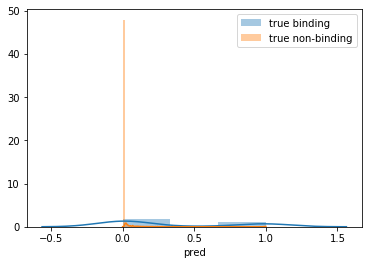

In [47]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
sns.distplot(df_pred['pred'][np.where(df_pred['result']==1)[0]]);
sns.distplot(df_pred['pred'][np.where(df_pred['result']==0)[0]]);
plt.legend(labels=['true binding','true non-binding'])

plt.show()

### ROC curve plot

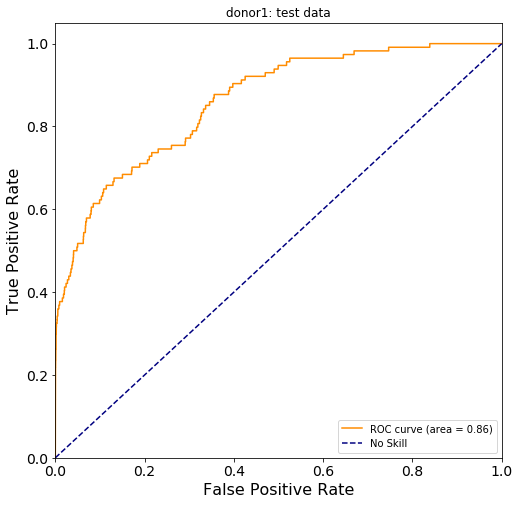

In [48]:
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score
plt.figure(figsize=(8,8))
fpr, tpr, thresholds= roc_curve(df_pred['result'],df_pred['pred'])
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, color='darkorange',
          label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--', label='No Skill')
 
plt.xticks(fontsize= 14) 
plt.yticks(fontsize= 14)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=16)
plt.ylabel('True Positive Rate', fontsize=16)
plt.title('donor1: test data')
plt.legend(loc="lower right")
plt.savefig('donor1_comb.png')
plt.show()

### Examine the performance for individual antigens

C:\Users\Anjin\Anaconda3\lib\site-packages\seaborn\distributions.py:283: UserWarning: Data must have variance to compute a kernel density estimate.
  warnings.warn(msg, UserWarning)


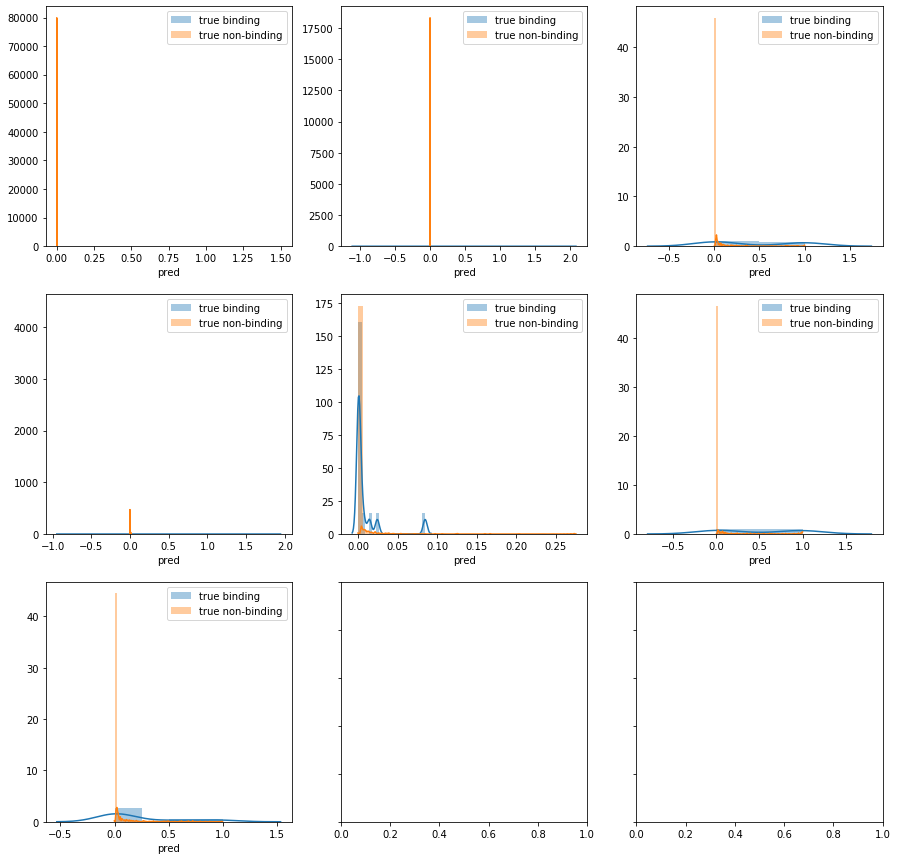

In [49]:
import matplotlib.pyplot as plt
antigen_train, antigen_test = train_test_split(input_seq_antigen,test_size=1/10, random_state=42)



fig, ax = plt.subplots(3, 3, sharex='col', sharey='row', figsize=(15,15))

counter=1
for i in np.unique(antigen_test):

    antigen_indices = [index for index, x in enumerate(antigen_test) if x == i]

        
    df_pred_pep=pd.DataFrame()
    df_pred_pep['pred']=pred[antigen_indices,0]
    df_pred_pep['result']=y_val[antigen_indices]
    

    fpr, tpr, thresholds= roc_curve(df_pred_pep['result'],df_pred_pep['pred'])
    from sklearn.metrics import confusion_matrix
    binary_pred=df_pred_pep['pred'].copy()
    binary_pred[np.where(binary_pred<=optimal_threshold)[0]]=0
    binary_pred[np.where(binary_pred>optimal_threshold)[0]]=1
    tn, fp, fn, tp = confusion_matrix(df_pred_pep['result'], binary_pred).ravel()
    sens_ = tp / (tp + fn)
    acc_ = (tp + tn) / (tp + tn + fn + fp)
    sp_ = tn / (tn + fp)
    pr_ = tp / (tp + fp)

    roc_auc = auc(fpr, tpr)
    plt.subplot(3, 3, counter)
    sns.distplot(df_pred_pep['pred'][np.where(df_pred_pep['result']==1)[0]]);
    sns.distplot(df_pred_pep['pred'][np.where(df_pred_pep['result']==0)[0]]);
    plt.legend(labels=['true binding','true non-binding'])


    counter=counter+1
plt.savefig('donor1test_sep.png')
plt.show()
        

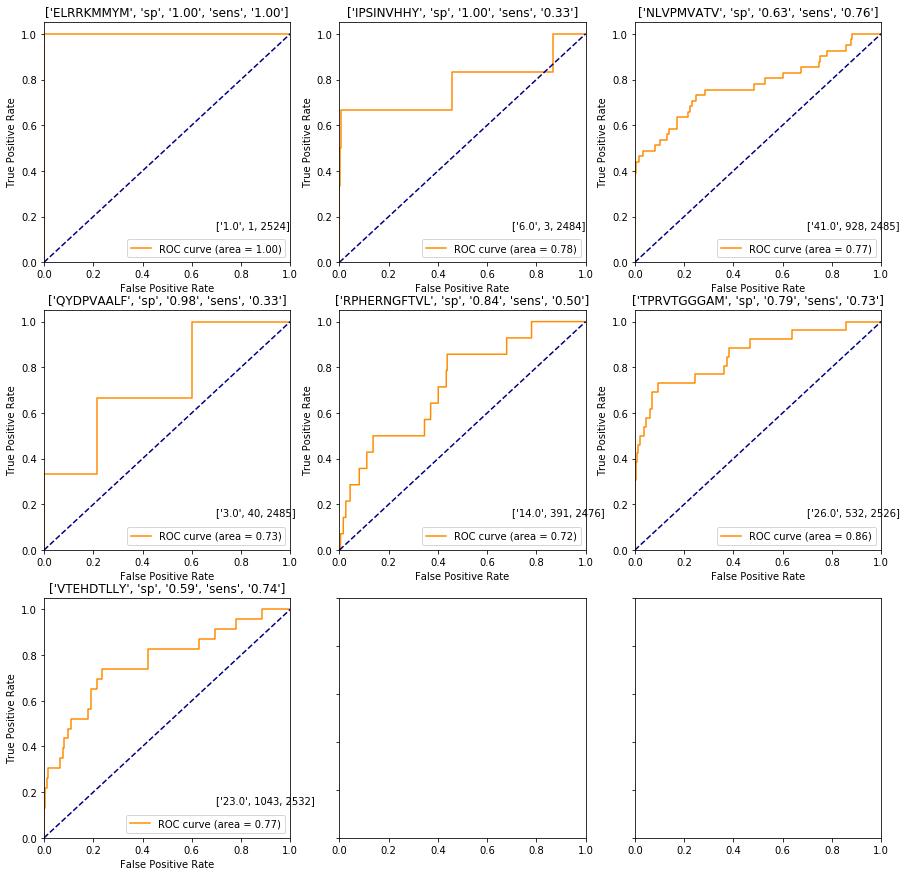

In [50]:
import matplotlib.pyplot as plt
antigen_train, antigen_test = train_test_split(input_seq_antigen,test_size=1/10, random_state=42)



fig, ax = plt.subplots(3, 3, sharex='col', sharey='row', figsize=(15,15))

counter=1
for i in np.unique(antigen_test):

    antigen_indices = [index for index, x in enumerate(antigen_test) if x == i]

        
    df_pred_pep=pd.DataFrame()
    df_pred_pep['pred']=pred[antigen_indices,0]
    df_pred_pep['result']=y_val[antigen_indices]
    

    fpr, tpr, thresholds= roc_curve(df_pred_pep['result'],df_pred_pep['pred'])
    from sklearn.metrics import confusion_matrix
    binary_pred=df_pred_pep['pred'].copy()
    binary_pred[np.where(binary_pred<=optimal_threshold)[0]]=0
    binary_pred[np.where(binary_pred>optimal_threshold)[0]]=1
    tn, fp, fn, tp = confusion_matrix(df_pred_pep['result'], binary_pred).ravel()
    sens_ = tp / (tp + fn)
    acc_ = (tp + tn) / (tp + tn + fn + fp)
    sp_ = tn / (tn + fp)
    pr_ = tp / (tp + fp)

    roc_auc = auc(fpr, tpr)
    plt.subplot(3, 3, counter)
    plt.plot(fpr, tpr, color='darkorange',
              label='ROC curve (area = %0.2f)' % roc_auc)
    plt.text(0.7,0.15,[str(sum(df_pred_pep['result'])), 
               sum(df_pred_pep['pred']>optimal_threshold), len(df_pred_pep['pred'])])
    plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title([str(np.unique(antigen_test)[(counter-1)]),
               'sp','{:.2f}'.format(sp_),
               #'pr_','{:.2f}'.format(pr_),
               'sens','{:.2f}'.format(sens_)])
              #,'pr_','{:.2f}'.format(pr_)
    plt.legend(loc="lower right")
    counter=counter+1
plt.savefig('donor1test_sep.png')
plt.show()
        

### use the previously determined optimal threshold to decide the binding outcome

In [51]:
#optimal_threshold=0.9
binary_pred=df_pred['pred'].copy()
binary_pred[np.where(binary_pred<=optimal_threshold)[0]]=0
binary_pred[np.where(binary_pred>optimal_threshold)[0]]=1

## Precision recall curve

Logistic: f1=0.051


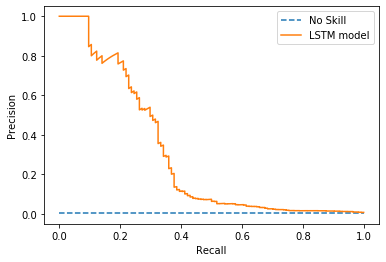

In [52]:

# precision-recall curve and f1
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import f1_score
from sklearn.metrics import auc
from matplotlib import pyplot

lr_precision, lr_recall, _ = precision_recall_curve(df_pred['result'], df_pred['pred'])

lr_f1 = f1_score(df_pred['result'], binary_pred)
#summarize scores
print('Logistic: f1=%.3f' % (lr_f1))
# plot the precision-recall curves
no_skill = len(df_pred['result'][df_pred['result']==1]) / len(df_pred['result'])
pyplot.plot([0, 1], [no_skill, no_skill], linestyle='--', label='No Skill')
pyplot.plot(lr_recall, lr_precision, marker='', label='LSTM model')
# axis labels
pyplot.xlabel('Recall')
pyplot.ylabel('Precision')
plt.plot(range(0, 1))
# show the legend
pyplot.legend()
# show the plot
pyplot.show()



In [53]:
confusion_matrix(df_pred['result'], binary_pred)

array([[14538,  2860],
       [   36,    78]], dtype=int64)

### calculate metrics

In [54]:
from sklearn.metrics import confusion_matrix
tn, fp, fn, tp = confusion_matrix(df_pred['result'], binary_pred).ravel()
# Error rate : 
err_rate = (fp + fn) / (tp + tn + fn + fp)
print("Error rate  : ", round(err_rate,3))
# Accuracy : 
acc_ = (tp + tn) / (tp + tn + fn + fp)
print("Accuracy  : ", round(acc_,3))
# Sensitivity/recall : 
sens_ = tp / (tp + fn)
print("Sensitivity  : ", round(sens_,3))
# Specificity 
sp_ = tn / (tn + fp)
print("Specificity  : ", round(sp_,3))
# False positive rate (FPR)
FPR = fp / (tn + fp)
print("False positive rate  : ", round(FPR,3))
# Precision
pr_ = tp / (tp + fp)
print("Precision  : ", round(pr_,3))

# F1 score
f1_ = (2 * pr_ * sens_) / (pr_ + sens_)
print("F1 score  : ", round(f1_,3))

Error rate  :  0.165
Accuracy  :  0.835
Sensitivity  :  0.684
Specificity  :  0.836
False positive rate  :  0.164
Precision  :  0.027
F1 score  :  0.051


Calculate the percentage of positive binding events & the percentage of true positive binding events in the events predicted as positive

In [55]:
print('positive binding percentage:',sum(output)/len(output))
print('positive binding percentage within events predicted as positive:',tp/(tp+fp))

positive binding percentage: 0.00709811154827915
positive binding percentage within events predicted as positive: 0.02654867256637168
